In [1]:
import numpy as np
import pandas as pd
import GPy
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")

# Set the font to be serif, rather than sans
sns.set(font='serif')
    
# Make the background white, and specify the specific font family
sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

In [3]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [4]:
param_names = pd.read_csv('params.csv')['Var']

In [5]:
X = pd.read_csv('design_inputs.csv', header = None)
#X = pd.read_csv('design_inputs.csv', header=None, names=param_names)

In [6]:
scaler_X = StandardScaler()
scaler_X.fit(X)
X_scaled = pd.DataFrame(scaler_X.transform(X), columns=X.columns)

In [7]:
Y = pd.read_csv('design_outputs_capacity.csv', index_col=0)

In [8]:
start = datetime.date(2010, 1, 1)
x_labels = pd.date_range(start, start+relativedelta(months=len(Y)), freq='M')
Y.index = x_labels.map(lambda s: s.date())

In [9]:
def plot_fig(data, labels, number=None, legend=False, for_paper=False):
    mpl_fig = plt.figure(figsize = cm2inch(12.2, 6) if for_paper else (10,4))
    ax = mpl_fig.add_subplot(111)
    ax.set_xlabel(labels['x'])
    ax.set_ylabel(labels['y'])
    data.plot(ax=ax, legend=legend)
    
    if not for_paper:
        plt.title(labels["title"], fontsize=14)
    else:
        for label in ax.get_xticklabels()[::2]:
            label.set_visible(False)
        plt.savefig("Fig.{}.png".format(number), bbox_inches='tight');

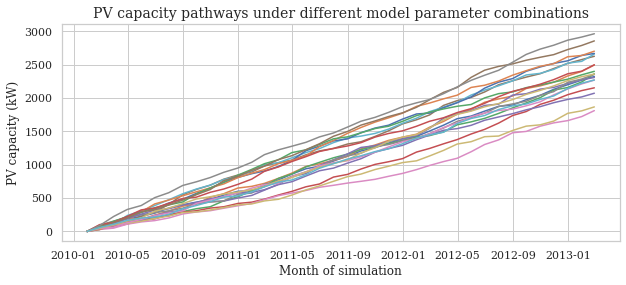

In [10]:
labels = {"x": "Month of simulation", "y": "PV capacity (kW)",
          "title": "PV capacity pathways under different model parameter combinations"}
plot_fig(Y, labels)


In [13]:
scaler_Y = MinMaxScaler()
scaler_Y.fit(np.array([0, Y.iloc[-1].median()]).reshape(-1,1))
Y_scaled = pd.DataFrame(scaler_Y.transform(Y), index = Y.index)

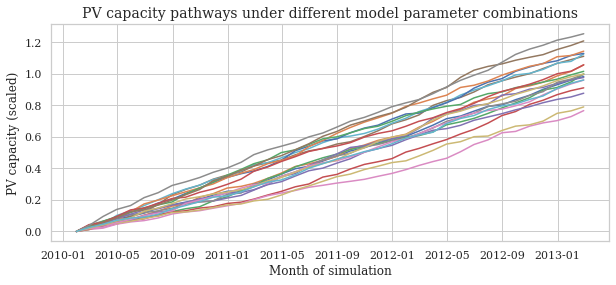

In [14]:
labels = {"x": "Month of simulation", "y": "PV capacity (scaled)",
          "title": "PV capacity pathways under different model parameter combinations"}
plot_fig(Y_scaled, labels)

In [15]:
def fit_GP(X_train, y_train, nfeatures, add_mean=False):
    if add_mean:
        mf = GPy.mappings.Linear(nfeatures,1)
    else:
        mf = None
    kernel = GPy.kern.Matern32(input_dim=nfeatures, ARD=True)
    
    if y_train.ndim < 2:
        y_train = np.expand_dims(y_train, axis=1)
        
    m = GPy.models.GPRegression(X_train, y_train, kernel, mean_function=mf)
    m.optimize_restarts(num_restarts = 3, verbose=True)
    return m

In [16]:
results = []
n_splits = 6
kf = KFold(n_splits=n_splits)
with tqdm(total=n_splits) as pbar:
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = Y_scaled.iloc[-1][train_index], Y_scaled.iloc[-1][test_index]
        m = fit_GP(X_train, y_train, 10)
        mu = m.predict(X_test.values)[0]
        predictions = np.fromiter((max(0, xi) for xi in mu), mu.dtype)
        results.append(1 - (np.power(y_test - predictions, 2).sum() / 
                            np.power(y_test - y_test.mean(), 2).sum()))
        pbar.update(1)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Optimization restart 1/3, f = -5.57047214886445
Optimization restart 2/3, f = -7.616159368422872
Optimization restart 3/3, f = -5.570473222703328


 17%|██████████████                                                                      | 1/6 [00:03<00:18,  3.66s/it] C:\Users\zoisk\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\zoisk\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\zoisk\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\zoisk\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply
 33%|████████████████████████████                                                        | 2/6 [00:03<00:10,  2.63s/it]

Optimization restart 1/3, f = -7.384138319911291
Optimization restart 2/3, f = -6.250589736857293
Optimization restart 3/3, f = -2.334627280303624
Optimization restart 1/3, f = -10.407562821068625
Optimization restart 2/3, f = -9.265191815717273


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:04<00:02,  1.44s/it]

Optimization restart 3/3, f = -10.286833983113372
Optimization restart 1/3, f = -6.767863918224057
Optimization restart 2/3, f = 9.190868759090776
Optimization restart 3/3, f = 0.12801190569016896
Optimization restart 1/3, f = -9.213295083574176
Optimization restart 2/3, f = 0.7379474279226059


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:04<00:01,  1.12s/it]

Optimization restart 3/3, f = -9.025666161485582
Optimization restart 1/3, f = -8.063575480586676
Optimization restart 2/3, f = -0.5569150295520409
Optimization restart 3/3, f = -0.16423838467457763

 C:\Users\zoisk\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.17it/s]

In [17]:
min(results)

-7.9969096949896645

In [18]:
m = fit_GP(X_scaled, Y_scaled.iloc[-1], 10)

Optimization restart 1/3, f = -11.215319574711124
Optimization restart 2/3, f = -9.471238237697497
Optimization restart 3/3, f = -10.96102385842669


In [23]:
import optunity

In [43]:
def rescale(column, params, index):
    interval = params.iloc[index]
    return column * (interval['Max'] - interval['Min']) + interval['Min']

In [60]:
num_pts = 10000   # the number of points to generate
skip = 1000     # the number of initial points of the Sobol sequence to skip
nfeatures = 10

# generate Sobol sequence
design = optunity.solvers.Sobol.i4_sobol_generate(2*nfeatures, num_pts, skip)

In [61]:
design = np.asarray(design)

In [63]:
A = design[:, :nfeatures]
B = design[:, nfeatures:]

In [51]:
params = pd.read_csv('params_after.csv')

In [66]:
for i in range(10):
    A[:, i] = rescale(A[:, i], params, i)
    B[:, i] = rescale(B[:, i], params, i)

In [107]:
A = scaler_X.transform(A)
B = scaler_X.transform(B)

In [108]:
f_A = m.predict(A)[0]
f_B = m.predict(B)[0]

In [93]:
def replace_with(destination, source, column):
    result = np.copy(destination)
    result[:, column] = source[:, column]
    return result

In [115]:
def calculate_var(factor, A, B, f_A, f_B, m):
    N, _ = A.shape
    A_B = replace_with(A, B, factor)
    return (1./N) * np.sum(f_B*(m.predict(A_B)[0] - f_A))

In [171]:
var_Y = np.var(Y_scaled.iloc[-1])

In [173]:
results = {}
for i, param in enumerate(param_names):
    results[param] = calculate_var(i, A, B, f_A, f_B, m) / var_Y

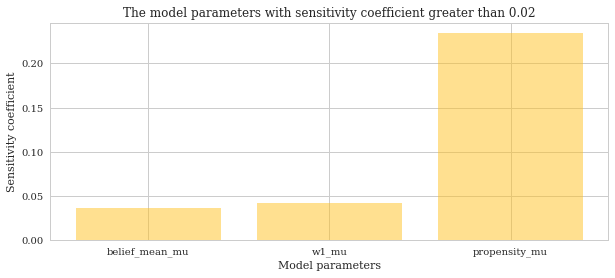

In [174]:
mpl_fig = plt.figure(figsize=(10,4))
ax = mpl_fig.add_subplot(111)

to_remove = []
for key, value in results.items():
    if value < 0.02:
        to_remove.append(key)
        
for k in to_remove:
    results.pop(k)

x, y = zip(*results.items()) 

x_pos = range(len(x))
plt.bar(x_pos, y, 
        align='center',
        # with color
        color='#FFC222',
        # alpha 0.5
        alpha=0.5)

plt.xticks(x_pos, x)

ax.set_xlabel("Model parameters")
ax.set_ylabel("Sensitivity coefficient")
ax.set_title("The model parameters with sensitivity coefficient greater than 0.02");

In [201]:
def with_last_day_of_month(year, month, any_day):
    any_day = datetime.date(year, month, any_day)
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

In [241]:
Y_mid_2010 = Y_scaled[Y_scaled.index == with_last_day_of_month(2010, 6, 1)]

In [244]:
m_mid_2010 = fit_GP(X_scaled, Y_mid_2010.values.T, 10)

Optimization restart 1/3, f = -254.42106276554645
Optimization restart 2/3, f = -258.29038437834777
Optimization restart 3/3, f = -258.28911062959384


In [246]:
Y_end_2010 = Y_scaled[Y_scaled.index == with_last_day_of_month(2010, 12, 1)]
m_end_2010 = fit_GP(X_scaled, Y_end_2010.values.T, 10)

Optimization restart 1/3, f = -169.4571593709422
Optimization restart 2/3, f = -169.45716597922416
Optimization restart 3/3, f = -169.4571483883065


In [248]:
Y_end_2011 = Y_scaled[Y_scaled.index == with_last_day_of_month(2011, 12, 1)]
m_end_2011 = fit_GP(X_scaled, Y_end_2011.values.T, 10)


Optimization restart 1/3, f = -92.91325430109544
Optimization restart 2/3, f = -92.91324234152793
Optimization restart 3/3, f = -92.91326889172245


In [249]:
m_end = m


In [205]:
requests = pd.read_csv('pv_connection_lic_requests.csv', 
                      converters={'Date': lambda s: datetime.datetime.strptime(s, "%d/%m/%Y").date()})
requests = requests.set_index('Date')
requests = requests[requests['Capacity (kW)'] <= 10]
requests = requests.sort_index()
requests = requests.loc[requests.index >= datetime.date(2010, 1, 1)]
requests = requests.loc[requests.index <= datetime.date(2013, 2, 1)]
requests = requests.groupby('Date').sum()
cumul_requests = requests.cumsum()

In [206]:
scaler_obs = MinMaxScaler()
scaler_obs.fit(cumul_requests.values.flatten().reshape(-1,1))
cumul_requests_sc = pd.DataFrame(scaler_obs.transform(cumul_requests), index = cumul_requests.index)

In [250]:
obs_mid_2010 = cumul_requests_sc.loc[cumul_requests_sc.index <= datetime.date(2010, 6, 30)].iloc[-1]
obs_end_2010 = cumul_requests_sc.loc[cumul_requests_sc.index <= datetime.date(2010, 12, 31)].iloc[-1]
obs_end_2011 = cumul_requests_sc.loc[cumul_requests_sc.index <= datetime.date(2011, 12, 31)].iloc[-1]
obs_end = cumul_requests_sc.loc[cumul_requests_sc.index >= datetime.date(2013, 1, 1)].iloc[-1]

In [208]:
from pyDOE import lhs

In [251]:
samples = lhs(10, samples=20000)

In [210]:
def rescale(column, params, index):
    interval = params.iloc[index]
    return column * (interval['Max'] - interval['Min']) + interval['Min']

In [252]:
params = pd.read_csv('params_after_sen.csv')

In [253]:
for i in range(10):
    samples[:, i] = rescale(samples[:, i], params, i)

In [255]:
samples = scaler_X.transform(samples)

In [213]:
import math

In [259]:
def implausibility(x, observed, emulators, Ves, Vem, period):
    return abs(observed[period-1] - emulators[period-1].predict(x)[0][0][0]) / math.sqrt(Ves + Vem)

In [215]:
from functools import partial
from tqdm import trange

In [291]:
period = 2
emul = [m_mid_2010, m_end_2010, m_end_2011 , m_end]
obs = [obs_mid_2010, obs_end_2010, obs_end_2011, obs_end]
response = partial(implausibility, observed=obs, emulators=emul, 
                            Ves=0.002, Vem=0.002, period=period)

In [292]:
results = []
for i in trange(len(samples)):
    results.append(response(samples[i,:].reshape(1,10)).values[0])

100%|███████████████████████████████████| 20000/20000 [01:41<00:00, 197.48it/s]


In [219]:
import prim

In [293]:
p = prim.Prim(samples, results, threshold=3, threshold_type="<")
box = p.find_box()
print(box)

Box 1 [Peeling Trajectory 25]
    Stats
        Coverage: 0.384525
        Density:  1.000000
        Mass:     0.277050
        Res Dim:  2.000000
        Mean:     1.000000
    Limits
                min       max     qp values
        4  0.203358  1.731112  0.000000e+00
        0 -1.731947  0.432504  7.166368e-72


In [268]:
def dummy_reverse(what, column):
    res = np.ones((2, 10))
    res[:, column] = np.asarray(what)
    return res

In [295]:
column = 0
scaler_X.inverse_transform(dummy_reverse([-1.7, 0.4], column))[:,column]

array([ 101.38555517,  192.29283343])